In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime

In [38]:
attendance_df = pd.read_csv('ttandance.csv')
attendance_df

,name,time,date
0,Dhoni,10:01:13,22-05-2024
1,Downey,10:01:57,22-05-2024
2,Ellon,10:02:19,22-05-2024
3,Kavin,10:03:07,22-05-2024
4,Navaneeth,10:04:03,22-05-2024
5,Pranavadhar,10:06:20,22-05-2024
6,Pranavsuriya,10:06:30,22-05-2024
7,Rohit,10:07:13,22-05-2024
8,Trump,10:07:36,22-05-2024
9,Usain,10:07:54,22-05-2024


Convert date and time to datetime

In [39]:
attendance_df['datetime'] = pd.to_datetime(attendance_df['date'] + ' ' + attendance_df['time'])
attendance_df = attendance_df.sort_values('datetime')
attendance_df.set_index('datetime', inplace=True)


C:\Users\prana\AppData\Local\Temp\ipykernel_6180\3521272692.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  attendance_df['datetime'] = pd.to_datetime(attendance_df['date'] + ' ' + attendance_df['time'])


Resample to compute entries per minute

In [40]:
entry_rate = attendance_df['name'].resample('1T').count()
entry_rate = entry_rate.rename('entry_rate')

C:\Users\prana\AppData\Local\Temp\ipykernel_6180\370417831.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  entry_rate = attendance_df['name'].resample('1T').count()


Plot the rate

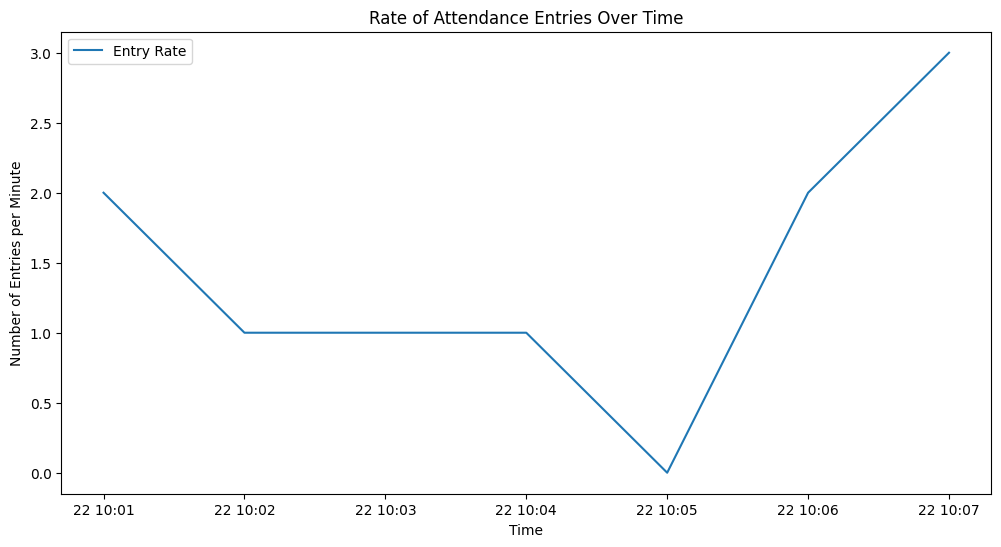

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(entry_rate, label='Entry Rate')
plt.xlabel('Time')
plt.ylabel('Number of Entries per Minute')
plt.title('Rate of Attendance Entries Over Time')
plt.legend()
plt.show()


LSTM model

In [42]:
entry_rate_values = entry_rate.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_entry_rate = scaler.fit_transform(entry_rate_values)

In [43]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 3  # Use past 3 minutes to predict the next minute
X, y = create_sequences(scaled_entry_rate, seq_length)

Reshape for LSTM [samples, time steps, features]

In [44]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [45]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))

c:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [47]:
model.fit(X, y, epochs=50, batch_size=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2383   
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3233     
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1722 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4374 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1540 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1639 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1636 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1295 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1307 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1117 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1469 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1104 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1397 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1260 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1804 
Epoch 16/50
4/4 ━━━━━━━━━━━━

In [48]:
predictions = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


In [49]:
predicted_entry_rate = scaler.inverse_transform(predictions)

In [50]:
print(predicted_entry_rate)

[[1.4869342]
 [1.4062765]
 [1.3626099]
 [1.3820406]]


Determine door open/close 

In [51]:
threshold = 2

In [52]:
door_status = ["Open" if rate > threshold else "Close" for rate in predicted_entry_rate]

Plot predictions and door status

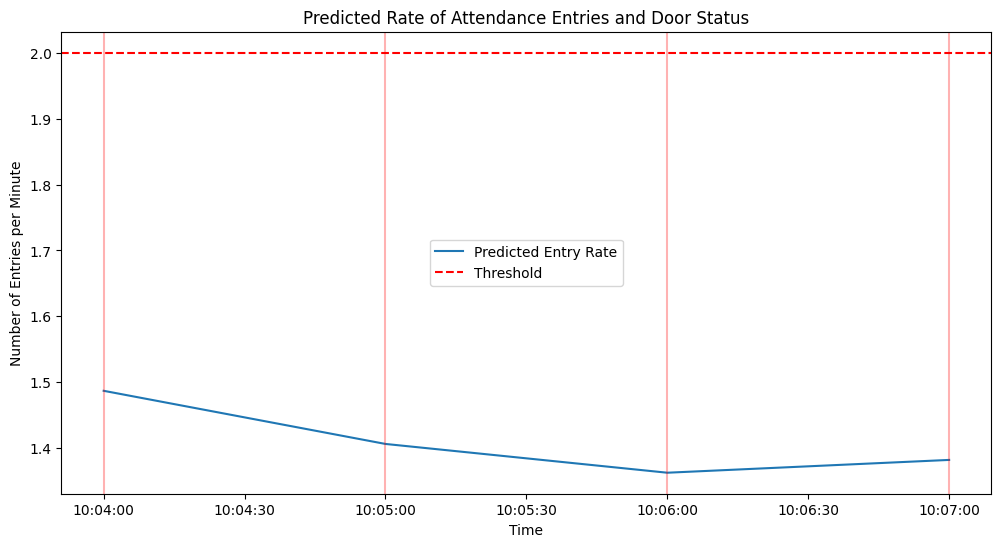

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(entry_rate.index[seq_length:], predicted_entry_rate, label='Predicted Entry Rate')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
for i, status in enumerate(door_status):
    color = 'green' if status == 'Open' else 'red'
    plt.axvline(entry_rate.index[seq_length:][i], color=color, alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Number of Entries per Minute')
plt.title('Predicted Rate of Attendance Entries and Door Status')
plt.legend()
plt.show()

In [54]:
for i, rate in enumerate(predicted_entry_rate):
    print(f"Predicted student entry rate: {rate[0]:.2f} students/minute")
    print(f"Door condition: {door_status[i]}")

Predicted student entry rate: 1.49 students/minute
Door condition: Close
Predicted student entry rate: 1.41 students/minute
Door condition: Close
Predicted student entry rate: 1.36 students/minute
Door condition: Close
Predicted student entry rate: 1.38 students/minute
Door condition: Close
